# Goal of the project
Our objective is from an audio waveform that contains background noise (such as a dog shouting in the background), to filter it out using a simple ESN architecture, composed of a single reservoir (lack of time and resource constraints to try other architectures). We present the full pipeline as well as hyperparameter optimization to improve the model even further.

# Execution

Optional (if you've done it already) : import & create datasets


In [ ]:
!wget https://openslr.trmal.net/resources/12/dev-clean.tar.gz
!wget https://github.com/karoldvl/ESC-50/archive/master.zip
!tar -xf dev-clean.tar.gz
!unzip master.zip
def prepare_dataset():
    import librispeech_data_fusion
    import esc50_librispeech_generation
    librispeech_data_fusion.main()
    esc50_librispeech_generation.main()
    
prepare_dataset()

Our dataset is composed of multiple different timeseries, which may not share the same length. As per the [documentation](https://github.com/reservoirpy/reservoirpy/blob/master/tutorials/1-Getting_Started.ipynb), we will have a list of NumPy arrays of shape (timesteps, features).

In our case, the number of features is simply the amplitude of the signal, so one feature.

The name of each input is directly coupled with the output filename. 

In [52]:
import librosa
import os
from constants import GENERATED_INPUT_DIRECTORY, OUTPUT_DIR
from collections import namedtuple
import numpy as np

AudioFile = namedtuple('AudioFile', ['filename', 'waveform'])  # global samplerate : 22050

# Ensure this notebook is run at the root of the project
input_files = os.listdir(GENERATED_INPUT_DIRECTORY)
output_files = os.listdir(OUTPUT_DIR)

# Pre-load file contents
input_files = [AudioFile(in_f, librosa.load(os.path.join(GENERATED_INPUT_DIRECTORY, in_f))[0]) for in_f in input_files]
output_files = [AudioFile(out_f, librosa.load(os.path.join(OUTPUT_DIR, out_f))[0]) for out_f in output_files]

data_input = []
data_output = []

# Format is defined as `file . noise_index . wav`
for out_file in output_files:
    # match output file with its associated inputs
    # (in other words, the original audio file, matched with the ones that have noise added to it)
    associated_inputs: list[AudioFile] = list(filter(lambda af: af.filename.split('.')[0] == out_file.filename.removesuffix('.wav'), input_files))
    for ai in associated_inputs:
        data_input.append(np.array(ai.waveform))
        data_output.append(np.array(out_file.waveform))



print(f"inputs : {data_input} \n \n outputs: {data_output}")

inputs : [array([ 0.00112915,  0.00140381,  0.00134277, ..., -0.00012207,
       -0.00030518, -0.00021362], shape=(4124020,), dtype=float32), array([-0.02819824, -0.13562012, -0.0819397 , ...,  0.04928589,
        0.01907349, -0.00393677], shape=(4124020,), dtype=float32), array([-0.00085449, -0.00088501, -0.0007019 , ..., -0.00021362,
       -0.00030518, -0.00021362], shape=(3216769,), dtype=float32), array([-0.03018188, -0.13790894, -0.08398438, ..., -0.13796997,
       -0.07983398, -0.08624268], shape=(3216769,), dtype=float32), array([-0.00158691, -0.00180054, -0.0010376 , ...,  0.00064087,
        0.00045776,  0.00012207], shape=(3299568,), dtype=float32), array([-0.03091431, -0.13882446, -0.08432007, ..., -0.0793457 ,
       -0.02780151,  0.05270386], shape=(3299568,), dtype=float32), array([ 0.        ,  0.        ,  0.        , ..., -0.00039673,
       -0.00042725, -0.00036621], shape=(3677619,), dtype=float32), array([-0.02932739, -0.13702393, -0.08328247, ..., -0.00579834,
  

We now have the data in the correct shape : for one cell of the `data_input` list at index `i`, we have the ouput to be predicted inside `data_output[i]`.

## ESN creation

In [53]:
import reservoirpy as rpy
from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy.datasets import mackey_glass
from reservoirpy import ESN

import numpy as np
import matplotlib.pyplot as plt

Formatting input data

165375


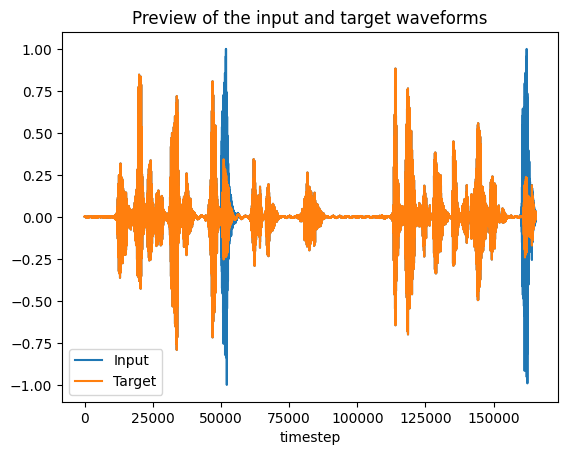

In [28]:
train_len = len(data_input[0])//4
test_len = len(data_input[0])//4
print(train_len)
forecast = 1

X_train = data_input[0][:train_len].reshape(-1, 1)
Y_train = data_output[0][forecast : train_len + forecast].reshape(-1, 1)

X_test = data_input[0][train_len : train_len+test_len-forecast].reshape(-1, 1)
Y_test = data_output[0][train_len + forecast: train_len+test_len].reshape(-1, 1)

dataset = (X_train, X_test, Y_train, Y_test)

plt.figure()
plt.plot(X_train, label="Input")
plt.plot(Y_train, label="Target")
plt.xlabel("timestep")
plt.title("Preview of the input and target waveforms")
plt.legend()
plt.show()

Creating a test ESN model

In [145]:
reservoir = Reservoir(100, lr=0.5, sr=0.9)
ridge = Ridge(ridge=1e-7)

esn_model = ESN(reservoir, ridge)

Fitting the basic model

In [146]:
esn_model = esn_model.fit(X_train, Y_train, warmup=10, workers=-1)
print(reservoir.initialized, ridge.initialized)


True True


## Run model

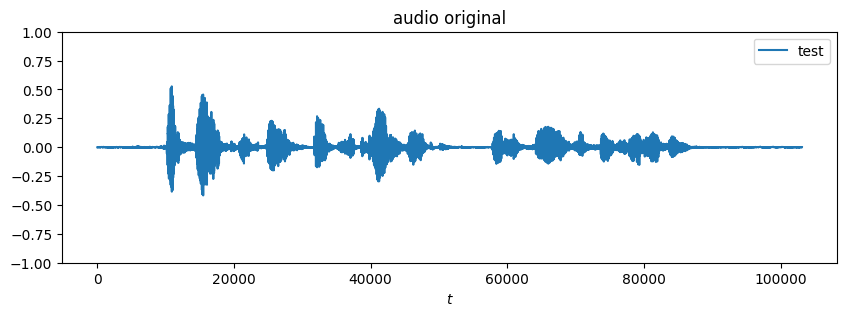

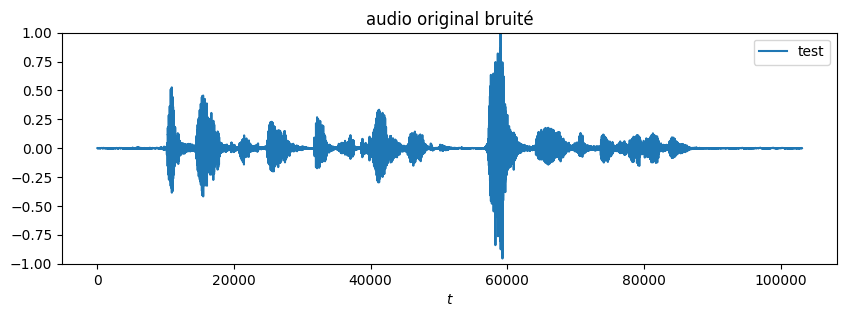

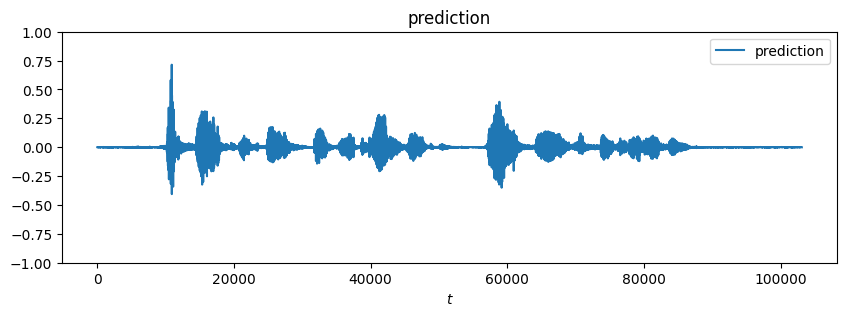

In [147]:
Y_pred = esn_model.run(X_test)

plt.figure(figsize=(10, 3))
plt.ylim(-1, 1)
plt.title("audio original")
plt.xlabel("$t$")
plt.plot(Y_test, label = "test")
plt.legend()

plt.figure(figsize=(10, 3))
plt.ylim(-1, 1)
plt.title("audio original bruité")
plt.xlabel("$t$")
plt.plot(X_test, label = "test")
plt.legend()

plt.figure(figsize=(10, 3))
plt.ylim(-1, 1)
plt.title("prediction")
plt.xlabel("$t$")
plt.plot(Y_pred, label="prediction")
plt.legend()

plt.show()

### Exporting the result as audio files

In [148]:
import soundfile as sf

sf.write("audio_entree.wav", X_test, samplerate=22050)
sf.write("audio_sortie.wav", Y_pred, samplerate=22050)

## Hyperparameter optimization
We use hyperopt to try and optimize further our model for noise reduction

In [ ]:
from reservoirpy.observables import nrmse, rsquare

# Objective functions accepted by ReservoirPy must respect some conventions:
#  - dataset and config arguments are mandatory, like the empty '*' expression.
#  - all parameters that will be used during the search must be placed after the *.
#  - the function must return a dict with at least a 'loss' key containing the result of the loss function.
# You can add any additional metrics or information with other keys in the dict. See hyperopt documentation for more informations.
def objective(dataset, config, *, input_scaling, N, sr, lr, ridge, seed):
    # This step may vary depending on what you put inside 'dataset'
    x_train, x_test, y_train, y_test = dataset
    
    # You can access anything you put in the config file from the 'config' parameter.
    instances = config["instances_per_trial"]
    
    # The seed should be changed across the instances to be sure there is no bias in the results due to initialization.
    variable_seed =     seed 
    
    losses = []; r2s = [];
    for n in range(instances):
        # Build your model given the input parameters
        reservoir = Reservoir(
            units=N, 
            sr=sr, 
            lr=lr, 
            input_scaling=input_scaling, 
            seed=variable_seed
        )

        readout = Ridge(ridge=ridge)

        model = reservoir >> readout


        # Train your model and test your model.
        predictions = model.fit(x_train, y_train) \
                           .run(x_test)
        
        loss = nrmse(y_test, predictions, norm_value=np.ptp(x_train))
        r2 = rsquare(y_test, predictions)
        
        # Change the seed between instances
        variable_seed += 1
        
        losses.append(loss)
        r2s.append(r2)

    # Return a dictionnary of metrics. The 'loss' key is mandatory when using hyperopt.
    return {'loss': np.mean(losses),
            'r2': np.mean(r2s)}



Define the hyperopt config for parameter search

In [29]:
import json

hyperopt_config = {
    "exp": "hyperopt-multiscroll",    # the experimentation name
    "hp_max_evals": 200,              # the number of differents sets of parameters hyperopt has to try
    "hp_method": "random",            # the method used by hyperopt to chose those sets (see below)
    "seed": 42,                       # the random state seed, to ensure reproducibility
    "instances_per_trial": 5,         # how many random ESN will be tried with each sets of parameters
    "hp_space": {                     # what are the ranges of parameters explored
        "N": ["choice", 500],             # the number of neurons is fixed to 500
        "sr": ["loguniform", 1e-2, 10],   # the spectral radius is log-uniformly distributed between 1e-2 and 10
        "lr": ["loguniform", 1e-3, 1],    # idem with the leaking rate, from 1e-3 to 1
        "input_scaling": ["choice", 1.0], # the input scaling is fixed
        "ridge": ["loguniform", 1e-8, 1e1],        # and so is the regularization parameter.
        "seed": ["choice", 1234]          # an other random seed for the ESN initialization
    }
}

# we precautionously save the configuration in a JSON file
# each file will begin with a number corresponding to the current experimentation run number.
with open(f"{hyperopt_config['exp']}.config.json", "w+") as f:
    json.dump(hyperopt_config, f)

In [ ]:

%pip install tqdm
# run the hyperparameter search
from reservoirpy.hyper import parallel_research
best = parallel_research(objective, dataset, f"{hyperopt_config['exp']}.config.json", ".")


[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: tqdm in c:\users\anton\appdata\local\programs\python\python310\lib\site-packages (4.67.1)



100%|██████████| 200/200 [42:38<00:00, 12.79s/trial, best loss=0.00906]   


In [30]:
from reservoirpy.hyper import plot_hyperopt_report
fig = plot_hyperopt_report(hyperopt_config["exp"], ("lr", "sr", "ridge"), metric="r2")

ValueError: zero-size array to reduction operation minimum which has no identity

![](./hyperopt_result.jpg)

Result of hyperparameter search : 

```
({'N': 500, 'sr': np.float64(0.974075540834452), 'lr': np.float64(0.7359863692998213), 'input_scaling': 1.0, 'ridge': np.float64(3.7845656386038534e-06), 'seed': 1234}, np.float64(0.00906349434922965))
```

Plugging these parameters into a new model

True True


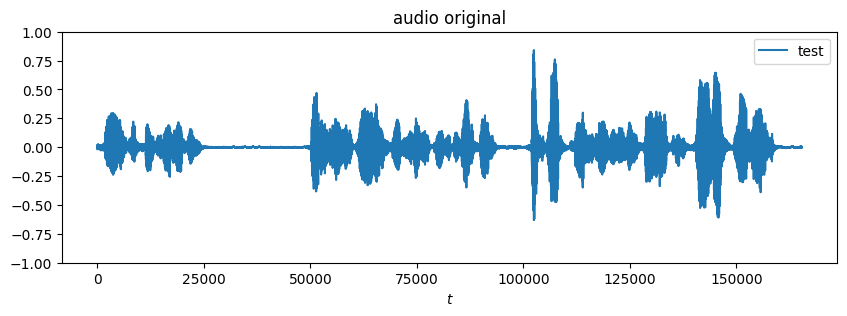

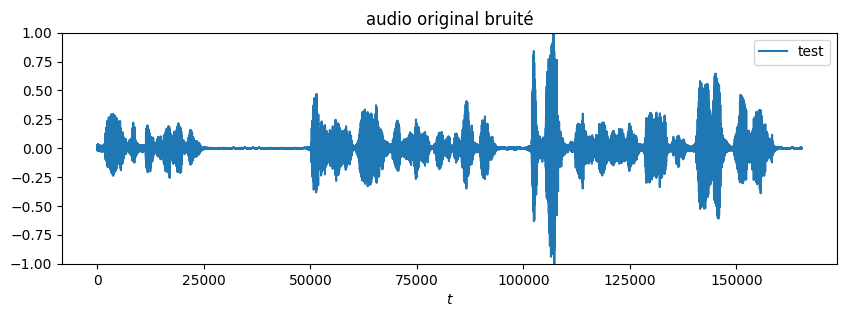

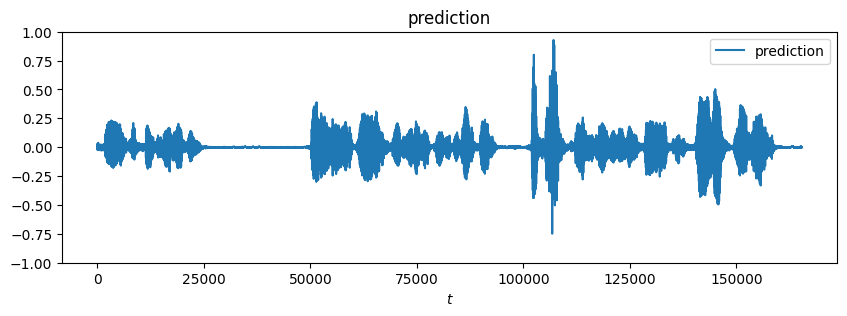

In [31]:
reservoir = Reservoir(100, lr=0.7359863692998213, sr=0.974075540834452, input_scaling=1.0)
ridge = Ridge(ridge=3.7845656386038534e-06)

esn_model = ESN(reservoir, ridge)
esn_model = esn_model.fit(X_train, Y_train, warmup=10, workers=-1)
print(reservoir.initialized, ridge.initialized)

Y_pred = esn_model.run(X_test)

plt.figure(figsize=(10, 3))
plt.ylim(-1, 1)
plt.title("audio original")
plt.xlabel("$t$")
plt.plot(Y_test, label = "test")
plt.legend()

plt.figure(figsize=(10, 3))
plt.ylim(-1, 1)
plt.title("audio original bruité")
plt.xlabel("$t$")
plt.plot(X_test, label = "test")
plt.legend()

plt.figure(figsize=(10, 3))
plt.ylim(-1, 1)
plt.title("prediction")
plt.xlabel("$t$")
plt.plot(Y_pred, label="prediction")
plt.legend()

plt.show()

We can see some spikes have been diminshed in the predicted audio. We recommend listening to the audio, while we lost quality, there was still progress in de-noising our signal. The loss function for hyperparameter search might not be the most adapted, maybe we could've selected a signal correlation loss, such as what convolutional filters do.

In [ ]:
sf.write("audio_entree.wav", X_test, samplerate=22050)
sf.write("audio_sortie.wav", Y_pred, samplerate=22050)

After hyperparameter optimization, the result is not exactly convincing, but we can hear that the noise produced by the dog has been reduced slightly, so there is a slight progress in the result. Due to the super-high dimension of the problem studied (and the fact that we couldn't get any supercomputer cluster for training), we couldn't perform improved hyperparameter search (a 2min waveform sampled at 22050 Hz requires more than 12Gb of RAM !).